# PART 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1.Questions

### 1.a

In [62]:
class algorithms:
    # we define a single class that runs everything
    def __init__(self, algorithm, max_dims, number_of_training_sets, test_set_size):
        
        # user decides on the algorithm to use in the inputs
        # the other inputs increase run time with larger numbers
        
        if algorithm == "1-nn":
            self.algo = self.one_NN
        elif algorithm == "perceptron":
            self.algo = self.perceptron
        elif algorithm == "winnow":
            self.algo = self.winnow
        elif algorithm == "least squares":
            self.algo = self.least_squares
        else:
            raise ValueError("Wrong algorithm string input: please try '1-nn', 'winnow','perceptron','least squares'")
            
        self.algo_name = algorithm
        self.max_dims = max_dims
        self.number_of_training_sets = number_of_training_sets
        self.test_set_size= test_set_size
        self.results = np.zeros((max_dims,))
        self.m_per_dim = np.zeros((max_dims, number_of_training_sets))
        self.criterion = 0.1
        self.std_dev = np.zeros((max_dims,))
        
    def main_loop_method2(self):
        
        '''
        The main loop where everything is done and called:
        It loops through dimensions, then training sets then finds the minimum m that satisfies our error criterion
        '''
        
        m = 0 
        # We loop through dimensions
        for n in range(1, self.max_dims):
            
            print("Dimension {} out of {} with number of samples {}".format(n, self.max_dims, m), end="\r")
            test = np.random.choice(2, (self.test_set_size, n))*2 -1
            
            for i in range(self.number_of_training_sets):
                
                # We initiate a random seed for consistent plots
                np.random.seed(i)
                #m = int(m*0.8)
                m=0
                # we increment indices and create a test set
                error = 1
                #error_per_test = np.ones((self.number_of_training_sets,))
                
                while error >= self.criterion:   
                    
                    m += 1
                    
                    # we create new training sets
                    training = np.random.choice(2, (m,n))*2 -1
                    
                    # We compute the weights and labels of the test set given an algorithm
                    if self.algo_name == "1-nn":
                        labels = self.one_NN(training, training[:,0], test)
                    else:
                        weights = self.algo(training, training[:,0])
                        labels = np.sign(weights@test.T)
                        
                    # we compute the error and if it is lower than the criterion, we loop again
                    error = self.generalisation_error(labels, test[:,0])
                    
                    # We save the number of training examples that were needed for a particular dimension and training set
                    self.m_per_dim[n, i] = m
                    
                
            # We find the mean and st dev of the number of training points needed for a certain dimension
            self.results[n] = np.mean(self.m_per_dim[n,:])
            self.std_dev[n] = np.std(self.m_per_dim[n,:])
            
        # We can plot our results with errorbars
        
        plt.errorbar(np.linspace(0,self.max_dims, self.max_dims), self.results, yerr=self.std_dev, fmt=".")
        plt.xlabel("Dimensions of data n")
        plt.ylabel("Number of data points m")
        plt.title("Estimated number of samples to obtain 10% generalisation error with {}".format(self.algo_name))
        plt.show()
        
        # We return the results as well to be able to inspect them
        return self.results
    
    
    
    def main_loop_method1(self):

        '''
        The main loop where everything is done and called:
        It loops through dimensions, then finds the minimum m
        that satisfies our error criterion for a given number of training sets 
        '''

        # We loop through dimensions
        for n in range(1, self.max_dims):

            print("Dimension {} out of {} with number of samples {}".format(n, self.max_dims, m), end="\r")
            test = np.random.choice(2, (self.test_set_size, n)) * 2 - 1
            error = 1
            # We use the previous m minus 20% to help with computation
            m = 0
            
            
            while error >= self.criterion:

                # we increment indices and create a test set
                m += 1

                error_per_test = np.ones((self.number_of_training_sets,))

                for i in range(self.number_of_training_sets):

                    # we create new training sets
                    np.random.seed(i)
                    
                    # We initiate a random seed for consistent plots
                    training = np.random.choice(2, (m, n)) * 2 - 1

                    # We compute the weights and labels of the test set given an algorithm
                    if self.algo_name == "1-nn":
                        labels = self.one_NN(training, training[:, 0], test)
                    else:
                        weights = self.algo(training, training[:, 0])
                        labels = np.sign(weights @ test.T)

                    # we compute the error and if it is lower than the criterion, we loop again
                    error_per_test[i] = self.generalisation_error(labels, test[:, 0])

                    # We save the number of training examples that were needed for a particular dimension and training set
                    self.m_per_dim[n, i] = m

                error = np.mean(error_per_test)

            # We find the mean of the number of training points needed for a certain dimension
            self.results[n] = np.mean(self.m_per_dim[n, :])

        # We can plot our results: no errorbars :( 
        plt.plot(self.results, ".")
        plt.xlabel("Dimensions of data n")
        plt.ylabel("Number of data points m")
        plt.title("Estimated number of samples to obtain 10% generalisation error with {}".format(self.algo_name))
        plt.show()

        # We return the results as well to be able to inspect them
        return self.results
    
    def perceptron(self, X, Y):
        '''
        Perceptron algorithm that takes matrix of features X and vecotr of labels Y
        
        '''
        
        # Initialising values
        w = np.zeros((X.shape[1],))
        M = 0
        
        # We loop through the data points
        for i in range(X.shape[0]):
            y_pred = np.sign(np.dot(w, X[i,:]))
            
            # We modify weights if the algorithm got it wrong
            if y_pred*Y[i] <= 0:
                w += Y[i]*X[i,:]
                M += 1
                
            else:
                # We do nothing if it got it right
                pass
            
        return w

    
    def winnow(self, X, Y):
        '''
        Winnow algorithm that takes matrix of features X and vector of labels Y
        
        '''
        
        # Winnow takes inputs of 1s and 0s so we normalise our data
        normalise = lambda x: (x+1)/2

        X = normalise(X)
        Y = normalise(Y)

        n = X.shape[1]
        w = np.ones((X.shape[1],))
        
        # We loop through the datapoints
        for i in range(X.shape[0]):
            
            # We make our prediction
            if np.dot(w, X[i,:]) < n:
                y_pred = 0 
            else: 
                y_pred = 1
            
            # If our prediction is wrong we change our weights vector
            if y_pred != Y[i]:
                w *= 2**((Y[i]-y_pred)*X[i,:])

        return w

    def least_squares(self, X, Y):
        
        '''
        Least squares algorithm that takes matrix of features X and vector of labels Y
        
        '''
        
        # We can use the normal equation with pseudo inverse for stability
        w = np.linalg.pinv(X.T @ X) @ X.T @ Y

        return w 

    def one_NN(self, X, Y, Z):
        
        '''
        1-NN algorithm that takes matrix of features X and vector of labels Y
        
        '''
        normalise = lambda x: (x+1)/2    
        X = normalise(X)
        Y = normalise(Y)
        Z = normalise(Z)
        prediction = np.zeros((Z.shape[0]))

        for i in range(Z.shape[0]):
            distance_matrix = X - Z[i, :]
            norm_vector = np.sum(distance_matrix**2, axis=1)
            closest_point = np.argmin(norm_vector)
            prediction[i] = Y[closest_point]

        return prediction*2 -1

    def generalisation_error(self, pred, labels):
        
        '''
        Generealisation error takes a prediction from our algorithm 
        trained with a specific training set and the true labels and returns the sum of errors 
        
        '''

        return 1/len(labels) * np.sum(pred != labels)

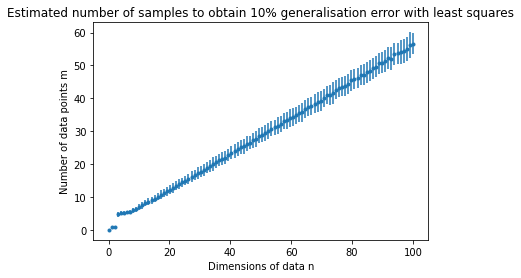

In [46]:
results_leastsq = algorithms(algorithm="least squares",max_dims=100, number_of_training_sets=200, test_set_size=400).main_loop_method2()

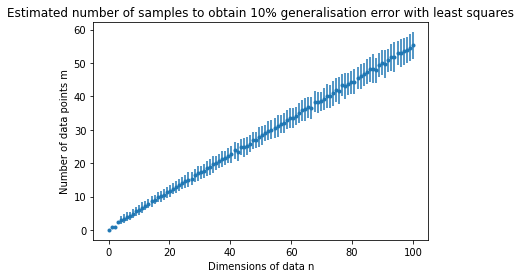

In [64]:
results_leastsq2 = algorithms(algorithm="least squares",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

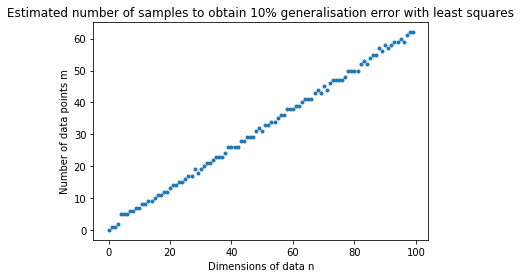

In [48]:
results_leastsq1 = algorithms(algorithm="least squares",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

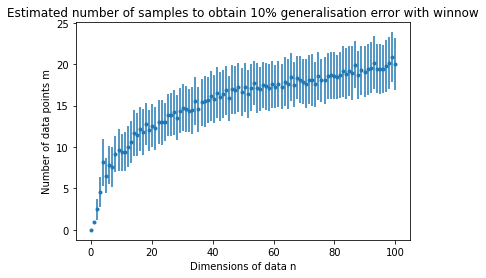

In [65]:
results_winnow = algorithms(algorithm="winnow",max_dims=100, number_of_training_sets=200, test_set_size=400).main_loop_method2()

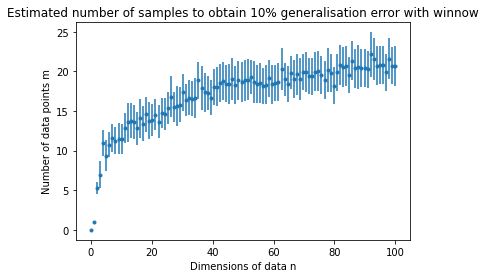

In [57]:
results_winnow2 = algorithms(algorithm="winnow",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

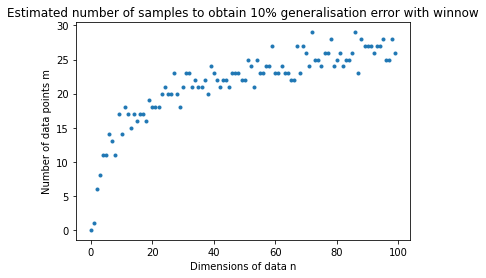

In [49]:
results_winnow1 = algorithms(algorithm="winnow",max_dims=100, number_of_training_sets=100, test_set_size=100).main_loop_method1()

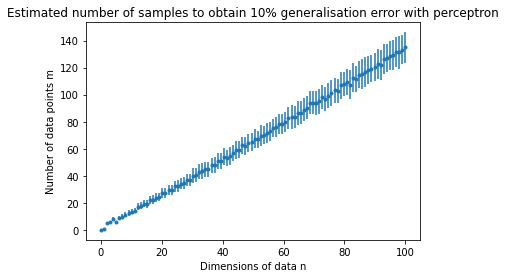

In [5]:
results_perceptron = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=200, test_set_size=400).main_loop_method2()

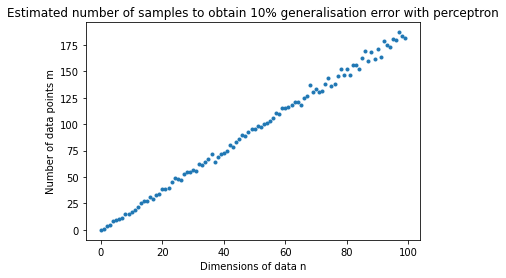

In [66]:
results_perceptron2 = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

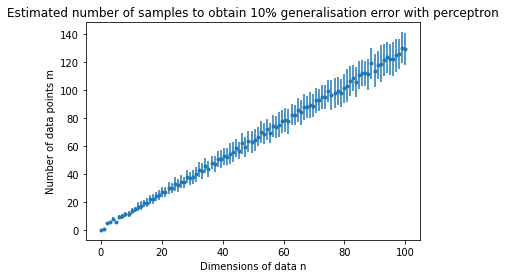

In [56]:
results_perceptron2 = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method2()

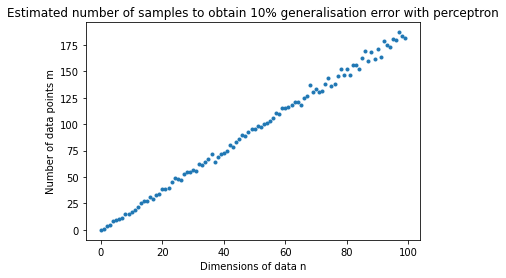

In [50]:
results_perceptron1 = algorithms(algorithm="perceptron",max_dims=100, number_of_training_sets=100, test_set_size=200).main_loop_method1()

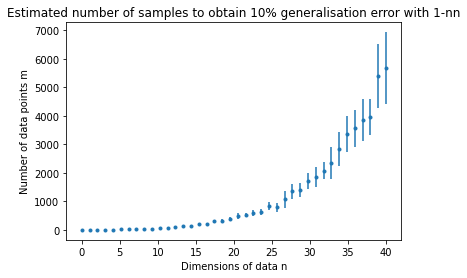

In [6]:
results_1nn = algorithms(algorithm="1-nn",max_dims=40, number_of_training_sets=50, test_set_size=100).main_loop()

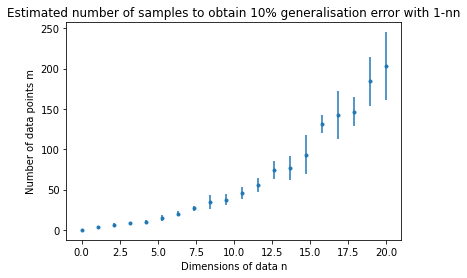

In [59]:
results_1nn2 = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=50).main_loop_method2()

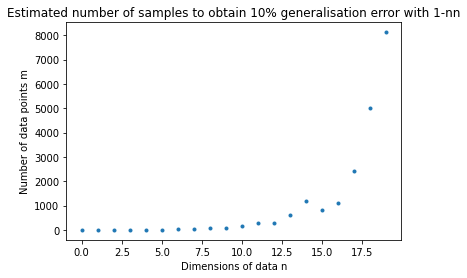

In [53]:
results_1nn1 = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=50).main_loop_method1()

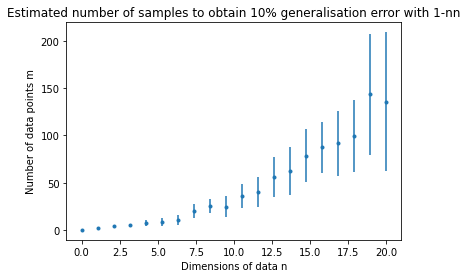

In [63]:
results_1nn1_0m = algorithms(algorithm="1-nn",max_dims=20, number_of_training_sets=20, test_set_size=50).main_loop_method2()

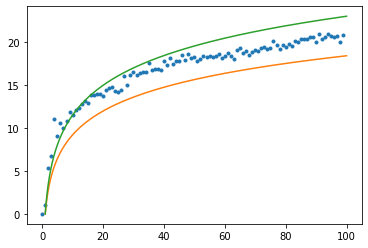

In [17]:
x = np.linspace(1,100,1000)
plt.plot(results_winnow,".")
plt.plot(x, np.log(x)*4)
plt.plot(x, np.log(x)*5)
plt.show()

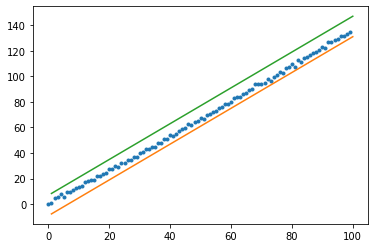

In [39]:
x = np.linspace(1,100,1000)
plt.plot(results_perceptron,".")
plt.plot(x, 1.4*x-9)
plt.plot(x, 1.4*x+7)
plt.show()

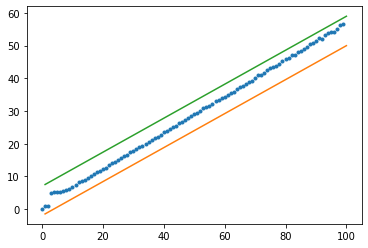

In [24]:
x = np.linspace(1,100,1000)
plt.plot(results_leastsq,".")
plt.plot(x, 0.52*x-2)
plt.plot(x, 0.52*x+7)
plt.show()

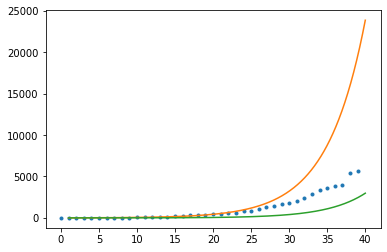

In [38]:
x = np.linspace(1,40,1000)
plt.plot(results_1nn,".")
plt.plot(x, 8*np.exp(0.2*x))
plt.plot(x, np.exp(0.2*x))
plt.show()

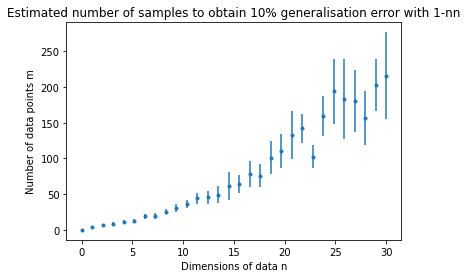

In [45]:
alg = algorithms(algorithm="1-nn",max_dims=30, number_of_training_sets=20, test_set_size=20)
tryout = alg.main_loop_method2()